In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import xarray as xr
import pandas as pd

In [3]:
diff = xr.open_dataset("I80diffs.nc")

In [4]:
diff

<xarray.Dataset>
Dimensions:    (Abs_PM: 164, day: 21, minute: 288)
Coordinates:
  * day        (day) |S14 b'2016_04_01.csv' b'2016_04_04.csv' ...
  * minute     (minute) int32 0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 ...
  * Abs_PM     (Abs_PM) float64 3.3 4.48 4.59 4.7 4.8 4.91 5.09 5.19 5.28 ...
Data variables:
    occupancy  (day, minute, Abs_PM) float64 0.0026 0.0031 0.002 0.0023 ...

In [5]:
d = diff['occupancy']

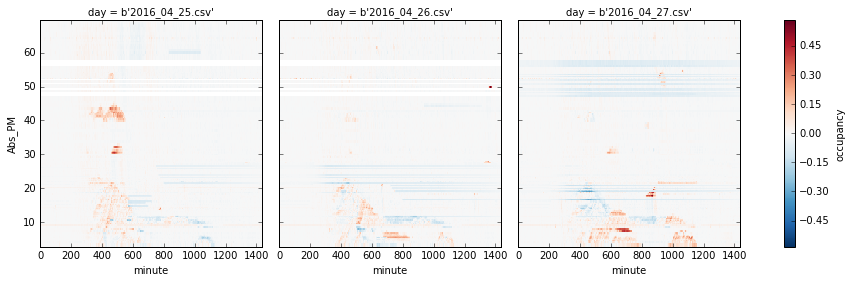

In [86]:
# Drop the first day to make a plot aligned on weekdays
d[16:19, :, :].plot.pcolormesh(x = "minute", y = "Abs_PM",
                            col = "day", col_wrap = 3, size = 4, aspect = 1)

#plt.title("difference in occupancy from median")
#plt.savefig("diffs.png")

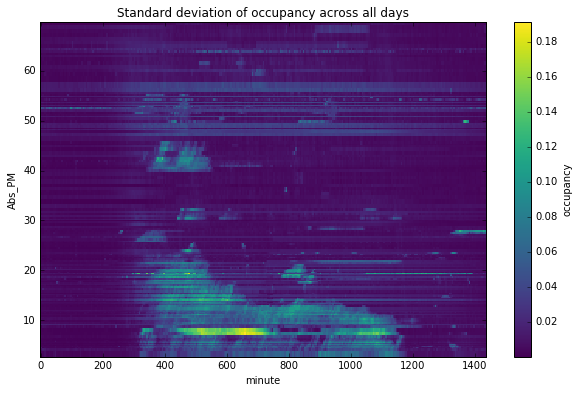

In [89]:
dsd = d.std("day")

plt.figure(figsize = (10, 6))
dsd.plot(x = "minute", y = "Abs_PM")
plt.title("Standard deviation of occupancy across all days")

plt.savefig("occ_sd.png")

In [74]:
plt.savefig?

The brighter colors on this plot correspond to times and locations where occupancy is highly variable.

We could add linear scaling such that areas of variable occupancy have low weight. `occupancy` loses the meaning, but it's still useful.

In [8]:
dsd_weight = 10 - 50 * dsd

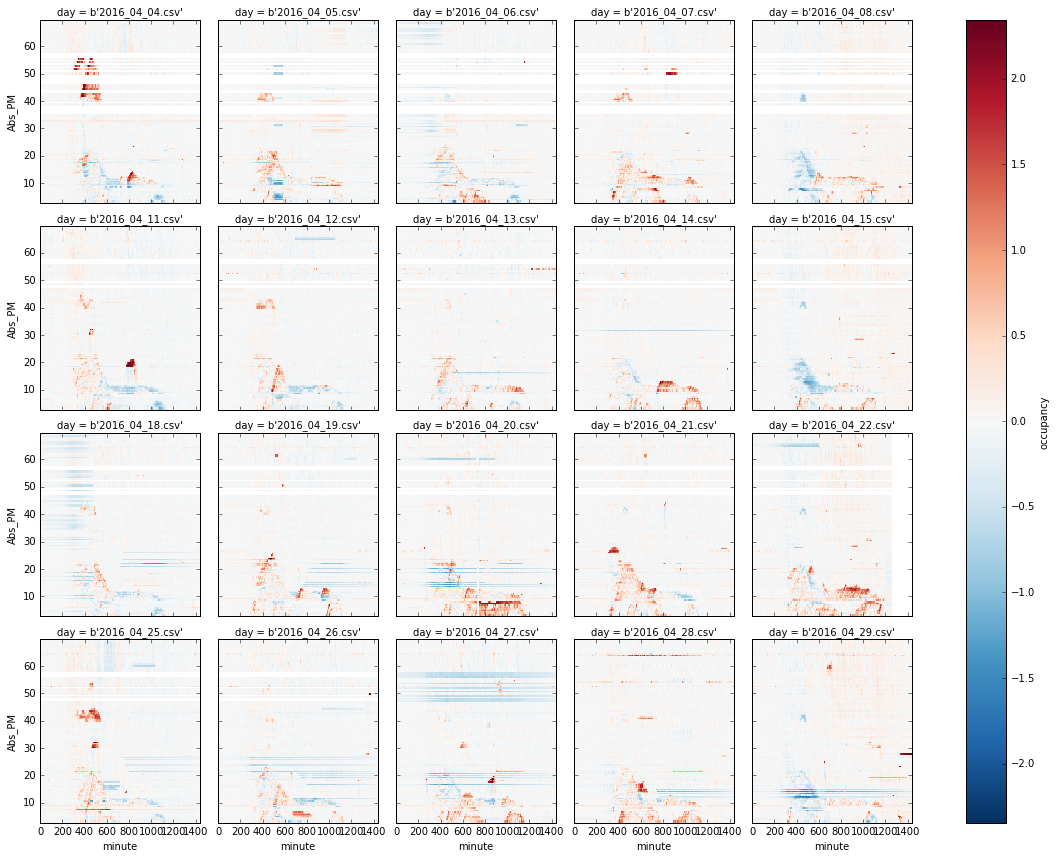

In [9]:
d2 = d * dsd_weight

d2[1:, :, :].plot.pcolormesh(x = "minute", y = "Abs_PM",
                            col = "day", col_wrap = 5, size = 3, aspect = 1)


The 29th looks like some interesting things happened. Let's plot the corresponding incidents on the density.

In [10]:
chp = pd.read_csv("chp_incidents_80W.csv")

chp["Abs_PM"] = (chp
                 .iloc[:, 17]
                 .astype("float")
                 )

chp["dt"] = chp.iloc[:, 3].str.extract("([0-9]{2}/[0-9]{2})/")

/home/clark/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


The 17th index is absolute postmile

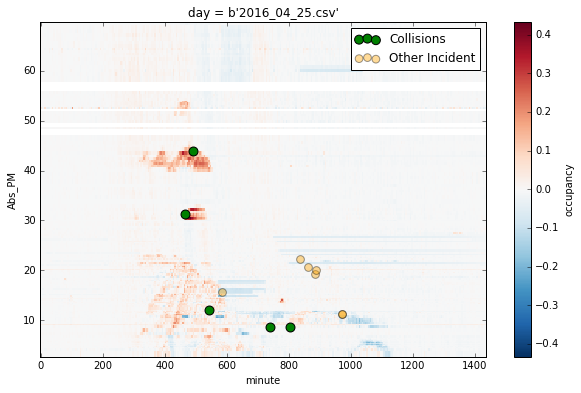

In [94]:
dc = d.sel(day = b"2016_04_25.csv")
dtpick = "04/25"
#dc = d2.sel(day = b"2016_04_25.csv")

plt.figure(figsize = (10, 6))
dc.plot(x = "minute", y = "Abs_PM")

rows = chp[chp["dt"] == dtpick]

# Add points for incidents
orange_pts = plt.scatter(rows["minute"], rows["Abs_PM"], c="orange", s=60, alpha=0.4, label="Other Incident")

# Green points correspond to collision
cl = rows[rows["collision"]]
green_pts = plt.scatter(cl["minute"], cl["Abs_PM"], c="green", s=80, label="Collisions")

plt.legend(handles=[green_pts, orange_pts])

plt.savefig("diffs.png")

Now lets see if we can write the thresholding algorithm to describe these areas numerically. For the image above I expect to get at least the ones around (450, 30), (450, 45).

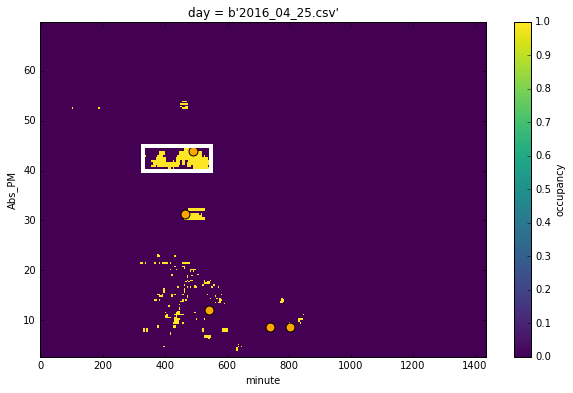

In [105]:
threshold = 0.1

dd = dc > threshold

plt.figure(figsize = (10, 6))
dd.plot(x = "minute", y = "Abs_PM")

plt.scatter(cl["minute"], cl["Abs_PM"], c="orange", s=80)

from matplotlib.patches import Rectangle
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((330, 40), 220, 5,
                      alpha=1, facecolor='none', edgecolor="white", lw=4))

plt.savefig("thresh.png")

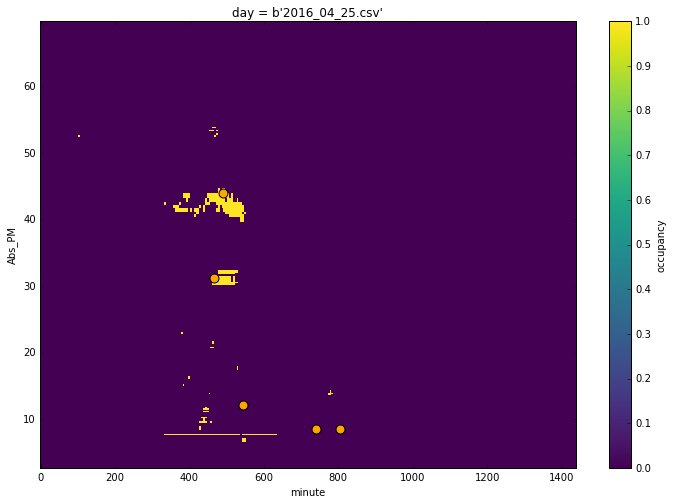

In [19]:
# Does weighting areas of low variance more heavily help eliminate noise? Yes.
# But this approach is a little too opaque, I'll do something simpler.

dd2 = d2.sel(day = b"2016_04_25.csv") > 1

plt.figure(figsize = (12, 8))
dd2.plot(x = "minute", y = "Abs_PM")

plt.scatter(cl["minute"], cl["Abs_PM"], c="orange", s=80)

## Angela's task

Write the code to get the bounding boxes around congestion areas. It should work on `dd` and similar matrices.

Goal is to see an answer like:

```
bbox(dd)
{"day": "04/25", "center_minute": 450, "center_Abs_PM": 45, "minute": 300, "Abs_PM": 7}
{"day": "04/25", "center_minute": 450, "center_Abs_PM": 45, "minute": 100, "Abs_PM": 3}
```

In [67]:
from scipy import ndimage
import xarray as xr


def summ_stats(slc, da):
    """
    Dictionary of summary statistics for each slice
    """
    mile = da[slc]["Abs_PM"]
    minute = da[slc]["minute"]
    d = {"minute_min": minute.min(),
            "minute_max": minute.max(),
            "Abs_PM_min": mile.min(),
            "Abs_PM_max": mile.max(),
            "pixels": da[slc].sum(),
            }
    d = {k: float(v) for k, v in d.items()}
    d["day"] = str(da["day"].values)
    return d


def process_image(da):
    """
    Process a single DataArray
    """
    lbl = ndimage.label(da)
    slices = ndimage.find_objects(lbl[0])
    return [summ_stats(slc, da) for slc in slices]

In [46]:
from collections import Counter
import itertools

out = process_image(dd)

Counter(x["pixels"] for x in out)

Counter({1.0: 51,
         2.0: 15,
         3.0: 7,
         4.0: 2,
         5.0: 3,
         6.0: 4,
         7.0: 1,
         8.0: 2,
         21.0: 1,
         29.0: 1,
         48.0: 1,
         71.0: 1,
         197.0: 1})

This suggests that to reduce noise we can filter out those which have less than a certain number of pixels.

In [68]:
largediff = d > threshold

ld = [process_image(x[1]) for x in iter(largediff.groupby("day"))]

# Flatten out the nesting
ld = list(itertools.chain(*ld))

In [69]:
traffic = pd.DataFrame(ld)

traffic.dtypes

Abs_PM_max    float64
Abs_PM_min    float64
day            object
minute_max    float64
minute_min    float64
pixels        float64
dtype: object

In [70]:
traffic["pixels"].value_counts().sort_index()

1.0      1016
2.0       371
3.0       157
4.0        94
5.0        58
6.0        48
7.0        28
8.0        28
9.0        15
10.0       21
11.0       15
12.0       13
13.0       14
14.0        9
15.0        5
16.0        8
17.0        3
18.0        5
19.0       13
20.0        5
21.0        7
22.0        2
23.0        2
24.0        3
25.0        5
26.0        4
27.0        4
28.0        3
29.0        3
31.0        2
         ... 
69.0        1
71.0        2
74.0        1
76.0        1
81.0        1
82.0        2
87.0        2
89.0        1
90.0        1
91.0        1
96.0        1
103.0       1
104.0       1
107.0       2
109.0       1
111.0       1
120.0       1
126.0       1
132.0       1
137.0       1
139.0       1
197.0       1
207.0       1
211.0       1
222.0       1
250.0       1
269.0       1
383.0       1
502.0       1
747.0       1
Name: pixels, dtype: int64

This suggests we could remove those with less than 10 pixels.

In [63]:
traffic.shape

(2036, 6)

In [71]:
t2 = traffic[traffic["pixels"] >= 10]
t2.shape

(221, 6)

In [72]:
t2.to_csv("traffic.csv", index = False)